In [1]:
from string import digits
import acquire
import prepare
import requests
from requests import get
from bs4 import BeautifulSoup
import os
import pandas as pd

import re
import unicodedata
import nltk

from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from wordcloud import WordCloud


%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

plt.rc('figure', figsize=(8, 10))

In [2]:
urls = acquire.get_urls()
df = acquire.get_readme_articles(urls=urls, cached=True)
df = prepare.clean_data(df)
train, validate, test = prepare.train_validate_test(df)
train.shape, validate.shape, test.shape

((63, 2), (21, 2), (21, 2))

In [3]:
#df = pd.read_json('project_readme.json')
df
#train

,title,content,language,text_cleaned,text_tokenized,text_lemmatized,text_filtered,words,doc_length
0,freecodecamp freecodecamp,\n\n\n\n\nfreeCodeCamp.org's open-source codeb...,javascript,\n\n\n\n\nfreecodecamporgs opensource codebase...,freecodecamporgs opensource codebase and curri...,freecodecamporgs opensource codebase and curri...,freecodecamporgs opensource codebase curriculu...,"[freecodecamporgs, opensource, codebase, curri...",707
1,famous famous,#THIS REPO IS DEPRECATED\n##Mixed Mode can be ...,javascript,this repo is deprecated\nmixed mode can be fou...,this repo is deprecated\nmixed mode can be fou...,this repo is deprecated mixed mode can be foun...,repo deprecated mixed mode found httpsgithubco...,"[repo, deprecated, mixed, mode, found, httpsgi...",30
2,vuejs vue,\n\n\n\n\n\n\n\n\n\n\nSupporting Vue.js\nVue.j...,javascript,\n\n\n\n\n\n\n\n\n\n\nsupporting vuejs\nvuejs ...,supporting vuejs\nvuejs is an mitlicensed open...,supporting vuejs vuejs is an mitlicensed open ...,supporting vuejs vuejs mitlicensed open source...,"[supporting, vuejs, vuejs, mitlicensed, open, ...",256
3,kevana uifordocker,UI For Docker\n\nThis repo is deprecated. Deve...,javascript,ui for docker\n\nthis repo is deprecated devel...,ui for docker\n\nthis repo is deprecated devel...,ui for docker this repo is deprecated developm...,ui docker repo deprecated development continue...,"[ui, docker, repo, deprecated, development, co...",337
4,facebook react,React · \nReact is a JavaScript library for...,javascript,react \nreact is a javascript library for ...,react \nreact is a javascript library for buil...,react react is a javascript library for buildi...,react react javascript library building user i...,"[react, react, javascript, library, building, ...",314
...,...,...,...,...,...,...,...,...,...
100,laincloud lain,LAIN\n\n\n\nLain 是一个基于 Docker 的 PaaS 系统。\n其面向技...,python,lain\n\n\n\nlain docker paas \ndevops start...,lain\n\n\n\nlain docker paas \ndevops startup ...,lain lain docker paas devops startup iaa idc l...,lain lain docker paas devops startup iaa idc l...,"[lain, lain, docker, paas, devops, startup, ia...",73
101,auth0 reposupervisor,Repo-supervisor\n\n\nThe Repo-supervisor is a ...,javascript,reposupervisor\n\n\nthe reposupervisor is a to...,reposupervisor\n\n\nthe reposupervisor is a to...,reposupervisor the reposupervisor is a tool th...,reposupervisor reposupervisor tool help detect...,"[reposupervisor, reposupervisor, tool, help, d...",610
102,weightagnostic weightagnosticgithubio,Weight Agnostic Neural Networks\nThis repo con...,javascript,weight agnostic neural networks\nthis repo con...,weight agnostic neural networks\nthis repo con...,weight agnostic neural network this repo conta...,weight agnostic neural network repo contains s...,"[weight, agnostic, neural, network, repo, cont...",93
103,jdorn phpreports,Php Reports\nA reporting framework for managin...,javascript,php reports\na reporting framework for managin...,php reports\na reporting framework for managin...,php report a reporting framework for managing ...,php report reporting framework managing displa...,"[php, report, reporting, framework, managing, ...",313


# What are the most common words in READMEs?

In [4]:
df.language.value_counts()

javascript    58
python        47
Name: language, dtype: int64

In [5]:
# getting rid of all the white spaces
df.language=df.language.apply(lambda x:x.strip())
train.language=df.language.apply(lambda x:x.strip())

In [6]:
# 
javascript_words = ' '.join(train[train.language=='javascript'].text_filtered)
python_words = ' '.join(train[train.language=='python'].text_filtered)

all_words = ' '.join(train.text_filtered)

javascript_words = re.sub(r'\s.\s', '', javascript_words)
python_words = re.sub(r'\s.\s', '', python_words)

all_words = re.sub(r'\s.\s', '', all_words)


In [7]:
# transforming to a panda series
javascript_freq = pd.Series(javascript_words.split()).value_counts()
python_freq = pd.Series(python_words.split()).value_counts()
all_freq = pd.Series(all_words.split()).value_counts()

python_freq.head()

video        205
file         191
use          174
youtubedl    143
model        115
dtype: int64

In [8]:
word_counts = (pd.concat([javascript_freq, python_freq, all_freq], axis=1, sort=True)
               .set_axis(['javascript', 'python', 'all'], axis=1, inplace=False)
               .fillna(0)
               .apply(lambda s: s.astype(int))
              )

word_counts.head()

,javascript,python,all
00,2,1,3
000,2,0,2
0000,0,1,1
00003,0,1,1
0001,0,1,1


In [9]:
word_counts.sort_values(by='all', ascending=False).head(10)

word_counts.python.sort_values(ascending = False).head(10)

video        205
file         191
use          174
youtubedl    143
model        115
download     109
format       106
code          94
example       92
using         90
Name: python, dtype: int64

In [10]:
word_counts.javascript.sort_values(ascending = False).head(10)

pod           434
file          142
node          140
label         136
container     131
new           112
kubectl       110
use           109
kubernetes    107
running       104
Name: javascript, dtype: int64

In [11]:
word_counts.sort_values(by='all', ascending=False).head(10)

,javascript,python,all
pod,434,0,434
file,142,191,333
use,109,174,283
video,2,205,207
using,95,90,185
run,91,82,173
new,112,53,165
see,99,55,154
code,58,94,152
example,56,92,148


# What does the distribution of IDFs look like for the most common words?

### Term Frequency

In [12]:
document = javascript_words#'Mary had a little lamb, a little lamb, a little lamb.'

# clean up the text
document = document.lower().replace(',', '').replace('.', '')
# transform into a series
words = pd.Series(document.split())

# From the Series we can extract the value_counts, which is our raw count
# for term frequency. Once we have the raw counts, we can calculate the
# other measures.
(pd.DataFrame({'raw_count': words.value_counts()})
 .assign(frequency=lambda df: df.raw_count / df.raw_count.sum())
 .assign(augmented_frequency=lambda df: df.frequency / df.frequency.max()))

,raw_count,frequency,augmented_frequency
pod,434,0.023625,1.000000
file,142,0.007730,0.327189
node,140,0.007621,0.322581
label,136,0.007403,0.313364
container,131,0.007131,0.301843
...,...,...,...
fulltime,1,0.000054,0.002304
trying,1,0.000054,0.002304
graphic,1,0.000054,0.002304
namespacedefault,1,0.000054,0.002304


In [13]:
document = python_words#'Mary had a little lamb, a little lamb, a little lamb.'

# clean up the text
document = document.lower().replace(',', '').replace('.', '')
# transform into a series
words = pd.Series(document.split())

# From the Series we can extract the value_counts, which is our raw count
# for term frequency. Once we have the raw counts, we can calculate the
# other measures.
(pd.DataFrame({'raw_count': words.value_counts()})
 .assign(frequency=lambda df: df.raw_count / df.raw_count.sum())
 .assign(augmented_frequency=lambda df: df.frequency / df.frequency.max()))

,raw_count,frequency,augmented_frequency
video,205,0.010834,1.000000
file,191,0.010094,0.931707
use,174,0.009196,0.848780
youtubedl,143,0.007557,0.697561
model,115,0.006078,0.560976
...,...,...,...
impossible,1,0.000053,0.004878
networkbased,1,0.000053,0.004878
validurl,1,0.000053,0.004878
mandate,1,0.000053,0.004878


In [14]:
document = all_words#'Mary had a little lamb, a little lamb, a little lamb.'

# clean up the text
document = document.lower().replace(',', '').replace('.', '')
# transform into a series
words = pd.Series(document.split())

# From the Series we can extract the value_counts, which is our raw count
# for term frequency. Once we have the raw counts, we can calculate the
# other measures.
(pd.DataFrame({'raw_count': words.value_counts()})
 .assign(frequency=lambda df: df.raw_count / df.raw_count.sum())
 .assign(augmented_frequency=lambda df: df.frequency / df.frequency.max()))

,raw_count,frequency,augmented_frequency
pod,434,0.011638,1.000000
file,333,0.008930,0.767281
use,283,0.007589,0.652074
video,207,0.005551,0.476959
using,185,0.004961,0.426267
...,...,...,...
ember,1,0.000027,0.002304
6476,1,0.000027,0.002304
forever,1,0.000027,0.002304
na,1,0.000027,0.002304


### Idf - Inverse Document Frequency

In [15]:
jdocs = dict(train[train.language=='javascript'].text_filtered)
pydocs = dict(train[train.language=='python'].text_filtered)

#def Merge(jdocs, pydocs): 
#    res = jdocs | pydocs
#    return res

langs = {**jdocs,**pydocs}


In [16]:
documents = langs
#jdocs = dict(train[train.language=='javascript'].text_filtered)

def idf(word):
    n_occurences = sum([1 for doc in documents.values() if word in doc])
    return len(documents) / n_occurences

# Get a list of the unique words
unique_words = pd.Series(' '.join(documents.values()).split()).unique()

# put the unique words into a data frame
(pd.DataFrame(dict(word=unique_words))
 # calculate the idf for each word
 .assign(idf=lambda train: train.word.apply(idf))
 # sort the data for presentation purposes
 .set_index('word')
 .sort_values(by='idf', ascending=False)
 .head(5))

,idf
word,
ethereumcasts,63.0
md5,63.0
selfogsearchdescriptionwebpage,63.0
exclusively,63.0
vuejsorg,63.0


# Does the length of the README vary by programming language?


In [17]:
train['doc_length'] = [len(wordlist) for wordlist in train.text_filtered]
train

,language,text_filtered,doc_length
78,python,deepgcns gcns go deep cnns work present new wa...,1602
34,python,home assistant configuration home assistant co...,2767
31,javascript,ethereumcasts companion repo ethereumsolidity ...,58
15,javascript,reactnativereduxcasts companion repo complete ...,233
7,python,knowledge repo knowledge repo project focused ...,534
...,...,...,...
57,javascript,babelstandalone part babel go check babelstand...,2802
4,javascript,react react javascript library building user i...,2300
56,javascript,chrome extension display repository size githu...,812
70,python,visual studio documentation welcome repo conta...,823


In [18]:
print('The avergage word count in python coded READMEs is:', train[train.language=='python'].doc_length.mean(), 'words')
train[train.language=='python'].describe()

The avergage word count in python coded READMEs is: 5485.857142857143 words


,doc_length
count,28.000000
mean,5485.857143
std,10445.931286
min,70.000000
25%,786.000000
50%,1750.000000
75%,5535.000000
max,54017.000000


In [19]:
print('The avergage word count in javascript coded READMEs is:', train[train.language=='javascript'].doc_length.mean(), 'words')
train[train.language=='javascript'].describe()

The avergage word count in javascript coded READMEs is: 4135.971428571429 words


,doc_length
count,35.000000
mean,4135.971429
std,10445.400999
min,37.000000
25%,583.500000
50%,1212.000000
75%,3109.500000
max,61828.000000


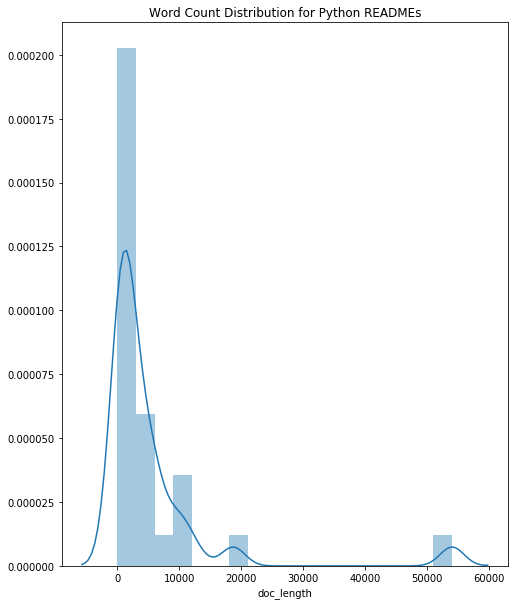

In [20]:
sns.distplot(train[train.language=='python'].doc_length)
plt.title('Word Count Distribution for Python READMEs')
plt.show()

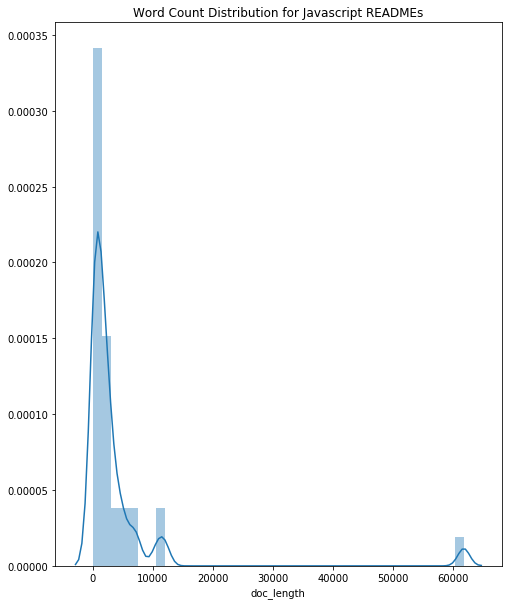

In [21]:
sns.distplot(train[train.language=='javascript'].doc_length)
plt.title('Word Count Distribution for Javascript READMEs')
plt.show()

# Do different programming languages use a different number of unique words?

<Figure size 936x504 with 0 Axes>

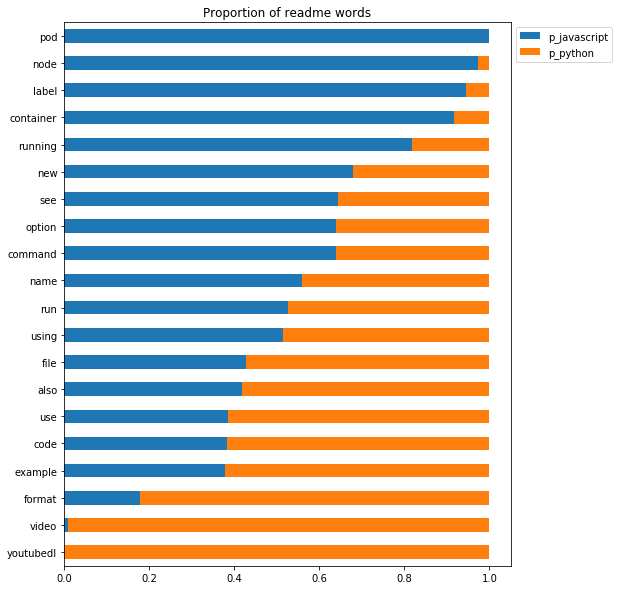

In [22]:
# visualize the percentage of the term in ham vs. spam
plt.figure(figsize = (13,7))
(word_counts.assign(p_javascript = word_counts.javascript/word_counts['all'], 
                   p_python = word_counts.python/word_counts['all'])
                   
 .sort_values(by='all')[['p_javascript', 'p_python']]
 .tail(20)
 .sort_values('p_javascript')
 .plot.barh(stacked=True)
)

plt.title("Proportion of readme words")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)

In [23]:
word_counts.sort_values(by='javascript', ascending=False).head(10)

,javascript,python,all
pod,434,0,434
file,142,191,333
node,140,4,144
label,136,8,144
container,131,12,143
new,112,53,165
kubectl,110,0,110
use,109,174,283
kubernetes,107,1,108
running,104,23,127


In [24]:
word_counts.sort_values(by='python', ascending=False).head(10)

,javascript,python,all
video,2,205,207
file,142,191,333
use,109,174,283
youtubedl,0,143,143
model,0,115,115
download,8,109,117
format,23,106,129
code,58,94,152
example,56,92,148
using,95,90,185


# Bag of words

In [25]:
from sklearn.feature_extraction.text import CountVectorizer

# Create CountVectorizer, which create bag-of-words model.
# stop_words : Specify language to remove stopwords. 
# min_df: ignore terms that have a document frequency strictly 
# lower than the given threshold. This value is also called cut-off in the literature. 
# If float, the parameter represents a proportion of documents, integer absolute counts. 
# ngram_range: the lower and upper boundary of the range of n-values for 
# different word n-grams or char n-grams to be extracted. 

vectorizer = CountVectorizer(stop_words='english', 
                             min_df=20, 
                             ngram_range=(1,2), 
                             binary=True)

# Learn vocabulary in sentences. 
vectorizer.fit(train.text_filtered)

# Get dictionary. 
vectorizer.get_feature_names()

['add',
 'build',
 'change',
 'check',
 'code',
 'create',
 'data',
 'different',
 'example',
 'feature',
 'file',
 'following',
 'github',
 'ha',
 'information',
 'install',
 'issue',
 'license',
 'like',
 'make',
 'need',
 'new',
 'note',
 'open',
 'project',
 'repo',
 'repository',
 'request',
 'run',
 'set',
 'source',
 'support',
 'update',
 'use',
 'used',
 'using',
 'version',
 'want',
 'work']

In [26]:
# Transform each sentences in vector space.
bow = vectorizer.transform(train.text_filtered)

In [27]:
# this is just to see the array of 0's and 1's
bow_array = bow.toarray()
bow_array[0]

array([0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1])

In [28]:
# Show sentences and vector space representation.
# purely to visualize what's happening.
for i, v in zip(train.text_filtered, bow_array):
    print(i)
    print(v)

deepgcns gcns go deep cnns work present new way successfully train deep gcns borrow concept cnns mainly residualdense connection dilated convolution adapt gcn architecture extensive experiment show positive effect deep gcn framework project paper slide tensorflow code pytorch code overview extensive experiment show different component layer filter nearest neighbor dilation etc effect deepgcns also provide ablation study different type deep gcns mrgcn edgeconv graphsage gin information detail please contact guohao li matthias muller requirement tensorflow 1120 h5py vtk needed visualization jupyter notebook needed visualization conda environment order setup conda environment neccessary dependency run conda env create f environmentyml getting started find detailed instruction use code semantic segmentation 3d point cloud folder semseg currently provide following conda environment setup s3dis dataset training code evaluation code several pretrained model visualization code citation please 

In [29]:
X_bow = bow

# TF-IDF

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words='english', min_df=20, 
                             ngram_range=(1,2), 
                             binary=True)

tfidf_sparse_matrix = tfidf.fit_transform(train.text_filtered)
tfidf_sparse_matrix

<63x39 sparse matrix of type '<class 'numpy.float64'>'
	with 1025 stored elements in Compressed Sparse Row format>

In [37]:
pd.DataFrame(tfidf_sparse_matrix.todense(), columns=tfidf.get_feature_names())

,add,build,change,check,code,create,data,different,example,feature,...,set,source,support,update,use,used,using,version,want,work
0,0.000000,0.000000,0.00000,0.000000,0.247313,0.310966,0.000000,0.310966,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.223113,0.000000,0.000000,0.000000,0.000000,0.292475
1,0.000000,0.000000,0.00000,0.256493,0.000000,0.261890,0.236870,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.279544,0.187902,0.273394,0.223855,0.251307,0.000000,0.000000
2,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.00000,0.000000,0.485839,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.438299,0.000000,0.000000,0.000000,0.610883,0.000000
4,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.377413,0.000000,0.00000,0.000000,...,0.000000,0.400417,0.000000,0.000000,0.000000,0.000000,0.356676,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,0.000000,0.252286,0.00000,0.262707,0.213329,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.192455,0.280018,0.229279,0.257396,0.268235,0.252286
59,0.200895,0.192926,0.20953,0.200895,0.163135,0.205123,0.185526,0.000000,0.18916,0.196834,...,0.000000,0.000000,0.200895,0.218950,0.147172,0.214133,0.175332,0.000000,0.000000,0.000000
60,0.354106,0.000000,0.00000,0.354106,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.354106,0.000000,0.000000,0.000000,0.259412,0.000000,0.000000,0.000000,0.000000,0.000000
61,0.000000,0.000000,0.00000,0.000000,0.269033,0.000000,0.000000,0.000000,0.00000,0.324608,...,0.000000,0.324608,0.000000,0.000000,0.242708,0.000000,0.000000,0.000000,0.000000,0.000000


In [38]:
# Get vocabularies.
tfidf.vocabulary_

{'work': 38,
 'new': 21,
 'project': 24,
 'code': 4,
 'different': 7,
 'information': 14,
 'run': 28,
 'create': 5,
 'use': 33,
 'following': 11,
 'license': 17,
 'like': 18,
 'ha': 13,
 'used': 34,
 'install': 15,
 'update': 32,
 'file': 10,
 'check': 3,
 'version': 36,
 'repo': 25,
 'using': 35,
 'data': 6,
 'note': 22,
 'want': 37,
 'make': 19,
 'source': 30,
 'need': 20,
 'set': 29,
 'add': 0,
 'example': 8,
 'change': 2,
 'support': 31,
 'github': 12,
 'repository': 26,
 'build': 1,
 'issue': 16,
 'request': 27,
 'open': 23,
 'feature': 9}

In [39]:
# Transform to document-term matrix
vector_spaces = tfidf.transform(train.text_filtered)
vector_spaces.toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.2924754 ],
       [0.        , 0.        , 0.        , ..., 0.25130727, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.354106  , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [40]:
# Show sentences and vector space representation.
# 
# (A, B) C
# A : Document Index
# B : Specific word-vector index
# C : TF-IDF score
for i, v in zip(train.text_filtered, vector_spaces):
    print(i)
    print(v)

deepgcns gcns go deep cnns work present new way successfully train deep gcns borrow concept cnns mainly residualdense connection dilated convolution adapt gcn architecture extensive experiment show positive effect deep gcn framework project paper slide tensorflow code pytorch code overview extensive experiment show different component layer filter nearest neighbor dilation etc effect deepgcns also provide ablation study different type deep gcns mrgcn edgeconv graphsage gin information detail please contact guohao li matthias muller requirement tensorflow 1120 h5py vtk needed visualization jupyter notebook needed visualization conda environment order setup conda environment neccessary dependency run conda env create f environmentyml getting started find detailed instruction use code semantic segmentation 3d point cloud folder semseg currently provide following conda environment setup s3dis dataset training code evaluation code several pretrained model visualization code citation please 

In [165]:
X_tfidf = tfidf_sparse_matrix

# Modeling

In [49]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer

#df = pd.read_csv('./data/spam_clean.csv')
#df.head()


# create our y dataset
y = train['language']

X_bow
X_tfidf

<63x39 sparse matrix of type '<class 'numpy.float64'>'
	with 1025 stored elements in Compressed Sparse Row format>

In [50]:
from sklearn.linear_model import LogisticRegression

lm = LogisticRegression().fit(X_bow, y)

train['predicted'] = lm.predict(X_bow)

In [51]:
from sklearn.metrics import confusion_matrix, classification_report

confusion_matrix(train.language, train.predicted)

array([[33,  2],
       [ 4, 24]])

In [52]:
pd.crosstab(train.language, train.predicted)

predicted,javascript,python
language,,
javascript,33,2
python,4,24


In [53]:
print(classification_report(train.language, train.predicted))

              precision    recall  f1-score   support

  javascript       0.89      0.94      0.92        35
      python       0.92      0.86      0.89        28

    accuracy                           0.90        63
   macro avg       0.91      0.90      0.90        63
weighted avg       0.91      0.90      0.90        63



In [54]:
lm_tfidf = LogisticRegression().fit(X_tfidf, y)
train['pred_tfidf'] = lm_tfidf.predict(X_tfidf)

In [55]:
pd.crosstab(train.language, train.pred_tfidf)

pred_tfidf,javascript,python
language,,
javascript,30,5
python,8,20


In [56]:
print(classification_report(train.language, train.pred_tfidf))

              precision    recall  f1-score   support

  javascript       0.79      0.86      0.82        35
      python       0.80      0.71      0.75        28

    accuracy                           0.79        63
   macro avg       0.79      0.79      0.79        63
weighted avg       0.79      0.79      0.79        63



In [185]:
def decisiontree_tfidf(df, target):

    tfidf = TfidfVectorizer(stop_words='english', min_df=5, 
                                     ngram_range=(1,2), 
                                     binary=True)

    tfidf_sparse_matrix = tfidf.fit_transform(df)
    X_tfidf = tfidf_sparse_matrix
    tree = DecisionTreeClassifier(max_depth=3, random_state=123)
    tree_fit = tree.fit(X_tfidf, target)
    train['predicted_tfidf'] = tree_fit.predict(X_tfidf)

    print(accuracy_score(target, train.predicted_tfidf))
    print(pd.crosstab(target, train.predicted_tfidf))
    print(classification_report(target, train.predicted_tfidf))
            

In [186]:
decisiontree_tfidf(train.text_filtered, train.language)

0.9047619047619048
predicted_tfidf  javascript  python
language                           
javascript               35       0
python                    6      22
              precision    recall  f1-score   support

  javascript       0.85      1.00      0.92        35
      python       1.00      0.79      0.88        28

    accuracy                           0.90        63
   macro avg       0.93      0.89      0.90        63
weighted avg       0.92      0.90      0.90        63



In [201]:
def decisiontree_xbow(X_bow, target):

    tree = DecisionTreeClassifier(max_depth=3, random_state=123)
    tree_fit = tree.fit(X_bow, target)
    train['predicted_xbow'] = tree_fit.predict(X_bow)

    print('Decision Tree Accuracy:',accuracy_score(target, train.predicted_xbow).round(2)*100, '%','\n')
    print(classification_report(target, train.predicted_xbow))
    print(pd.crosstab(target, train.predicted_xbow))

In [202]:
decisiontree_xbow(X_bow, train.language)

Decision Tree Accuracy: 81.0 % 

              precision    recall  f1-score   support

  javascript       0.79      0.89      0.84        35
      python       0.83      0.71      0.77        28

    accuracy                           0.81        63
   macro avg       0.81      0.80      0.80        63
weighted avg       0.81      0.81      0.81        63

predicted_xbow  javascript  python
language                          
javascript              31       4
python                   8      20


# Validate

In [57]:
# create our y dataset
y = validate['language']

X_bow_v
X_tfidf_v

<21x11292 sparse matrix of type '<class 'numpy.float64'>'
	with 13248 stored elements in Compressed Sparse Row format>

In [58]:
lm = LogisticRegression().fit(X_bow_v, y)

validate['predicted'] = lm.predict(X_bow_v)

In [59]:
from sklearn.metrics import confusion_matrix, classification_report

confusion_matrix(validate.language, validate.predicted)

array([[11,  0],
       [ 0, 10]])

In [ ]:
pd.crosstab(validate.language, validate.predicted)

In [ ]:
print(classification_report(validate.language, validate.pred_tfidf))

# Test

In [ ]:
# create our y dataset
y = test['language']

lm = LogisticRegression().fit(X_bow_t, y)

test['predicted'] = lm.predict(X_bow_t)

confusion_matrix(test.language, test.predicted)

In [ ]:
lm_tfidf_t = LogisticRegression().fit(X_tfidf_t, y)
test['pred_tfidf'] = lm_tfidf_t.predict(X_tfidf_t)

pd.crosstab(test.language, test.predicted)

In [ ]:
print(classification_report(test.language, test.pred_tfidf))

In [ ]:
tfidf = TfidfVectorizer(stop_words='english', min_df=4, 
                                 ngram_range=(1,2), 
                                 binary=True)
tfidf.fit(df.text_filtered)
y = df.language
X = tfidf.transform(df.text_filtered)

# define classifier
tree = DecisionTreeClassifier(max_depth=10, random_state=123)
tree.fit(X, y)

X = tfidf.transform(df1.text_filtered)
y = df1.language
tree.predict(X)

# > 2 languages

In [ ]:
#urls = acquire.get_urls()
#df = acquire.get_readme_articles(urls=urls, cached=True)
#df = prepare.clean_data(df)
#train, validate, test = prepare.train_validate_test(df)
#train.shape, validate.shape, test.shape

df1 = pd.read_json('project_readme1.json')
df1

In [ ]:
#prepare.tokenize(df1.language)

# ------------------------------------------------------------------------------------

In [63]:
url = 'https://github.com/nuxt/nuxt.js'
df1 = get_readme_articles(url,cached=False)

In [72]:
df1 = prepare.clean_data(df1)

In [73]:
df1

,title,content,language,text_cleaned,text_tokenized,text_lemmatized,text_filtered,words,doc_length
0,nuxt nuxtjs,\n\n\n\n \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,javascript,\n\n\n\n \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,build your next vuejs application with confide...,build your next vuejs application with confide...,build next vuejs application confidence using ...,"[build, next, vuejs, application, confidence, ...",267


In [209]:
url = 'https://github.com/Hari-Nagarajan/nvidia-bot'

def predict_readme(url):
    '''
    This function takes in a url and scrapes the README data to be cleaned and prepped.
    It is then run thru a decision tree classifier with the TF-IDF as its feature
    to determine the repository language'''
    
    df1 = get_readme_articles(url,cached=False)
    df1 = prepare.clean_data(df1)
    
    
    tfidf = TfidfVectorizer(stop_words='english', min_df=4, 
                                 ngram_range=(1,2), 
                                 binary=True)
    tfidf.fit(df.text_filtered)
    y = df.language
    X = tfidf.transform(df.text_filtered)

    # define classifier
    tree = DecisionTreeClassifier(max_depth=4, random_state=123)
    tree.fit(X, y)

    X = tfidf.transform(df1.text_filtered)
    y = df1.language
    prediction = tree.predict(X)
    return prediction
    

In [210]:
predict_readme(url)

array(['python'], dtype=object)

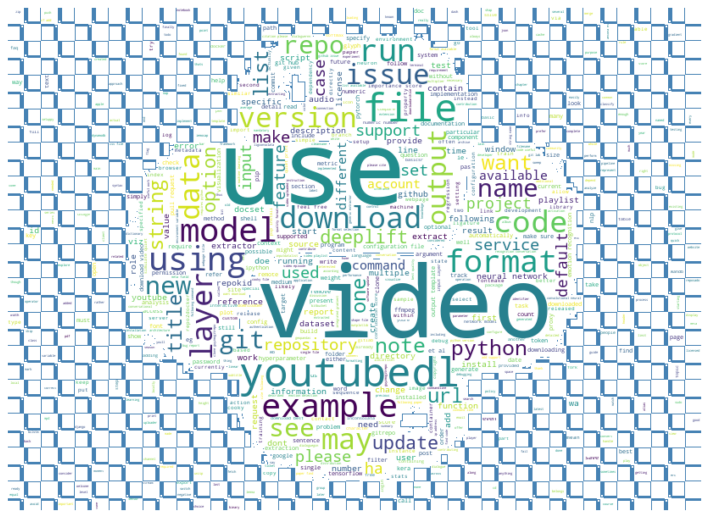

In [126]:
from PIL import Image
import numpy as np

python_mask = np.array(Image.open('pythonlogo.jpg'))
wc = WordCloud(background_color='white', mask=python_mask, mode='RGB',
               width=1000, max_words=1000, height=1000,
               random_state=1, contour_width=1, contour_color='steelblue')
wc.generate(python_words)
plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation='bilinear')
plt.tight_layout(pad=0)
plt.axis('off')
plt.show()

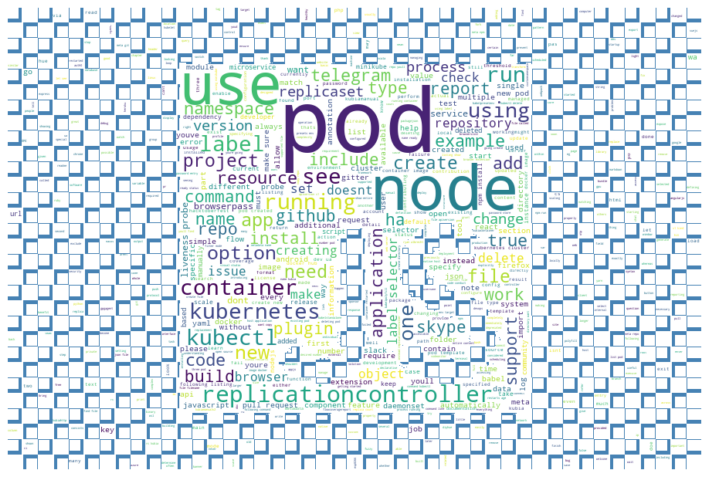

In [125]:
javascript_mask = np.array(Image.open('javascriptlogo.jpg'))
wc = WordCloud(background_color='white', mask=javascript_mask, mode='RGB',
               width=1000, max_words=1000, height=1000,
               random_state=1, contour_width=1, contour_color='steelblue')
wc.generate(javascript_words)
plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation='bilinear')
plt.tight_layout(pad=0)
plt.axis('off')
plt.show()